In [2]:
!pip install scikit-learn seaborn matplotlib pandas numpy scikit-image pillow scikit-fuzzy

In [1]:
from PIL import Image, ImageOps
import skfuzzy as fuzz
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage.transform import resize
from skimage import color, io, transform, util
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, auc, roc_auc_score, silhouette_score, silhouette_samples, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from scipy.fftpack import rfft, irfft
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle
import os

In [2]:
#source: https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b
def fourier_transform(image):
    image = np.array(image)
    fourier_image = np.fft.fftshift(np.fft.fft2(image))
    return fourier_image

def filter_fourier_image(fourier_image, low_cutoff, high_cutoff):  
    # Create a mask for the desired frequency range
    rows, cols = fourier_image.shape
    crow, ccol = rows//2, cols//2
    
    # Create a grid of distances from the center
    x = np.arange(rows).reshape((rows, 1))  # column vector
    y = np.arange(cols).reshape((1, cols))  # row vector
    distances = np.sqrt((x - crow) ** 2 + (y - ccol) ** 2)

    # Create a bandpass filter mask
    mask = (distances > low_cutoff) & (distances < high_cutoff)
    filtered_image = fourier_image * mask

    return filtered_image

def inverse_fourier_transform(f_transform ):
    image = abs(np.fft.ifft2(f_transform))
    return image

# source: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html https://kushalvyas.github.io/BOV.html
def sift_features(images):
    descriptor_extractor = SIFT()
    sift_features = []

    for i, img in enumerate(images):
        #print(f'{i} of {len(images)}')
        descriptor_extractor.detect_and_extract(img)
        descriptors = descriptor_extractor.descriptors
        if descriptors is not None:
            sift_features.append(descriptors)
            
    return sift_features


def bag_of_visual_words(sift_features, K):    
    # Concatenate all descriptors into a single array
    all_descriptors = np.vstack(sift_features)
    
    # set number of visual words 
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(all_descriptors)

    # Get the visual words (cluster centers)
    visual_words = kmeans.cluster_centers_
 
    histograms = []
    for i, descriptors in enumerate(sift_features):
        #print(f'{i} of {len(sift_features)}')
        # Predict which visual word each descriptor belongs to
        if descriptors.size != 0:
            visual_word_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(visual_word_indices, bins=np.arange(K + 1))
            histograms.append(histogram)
        else:
            # Append a histogram of zeros if no descriptors found
            histograms.append(np.zeros(K))

    # Create Bag-of-Visual-Words histograms
    return np.array(histograms)


def plot_ROC(y_test, y_scores, title):
    n_classes = len(set(labels))
    mlb = MultiLabelBinarizer(classes=range(n_classes))  
    y_test = mlb.fit_transform(y_test.reshape(-1, 1))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting ROC Curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

    mean_auc =  np.mean(list(roc_auc.values()))
    # Plot diagonal line (random chance)
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(title + '.png', bbox_inches='tight', dpi=300)
    plt.show()


def fuzzy_clustering(data, title):
    #standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    n_clusters = 5  
    fuzziness = 1.5  # Fuzziness factor

    # Apply Fuzzy C-Means
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data.T, c=n_clusters, m=fuzziness, error=0.005, maxiter=1000)

    # Get cluster memberships and labels
    cluster_membership = np.argmax(u, axis=0)
    
    # Calculate silhouette scores
    sample_silhouette_values = silhouette_samples(data, cluster_membership)

    # Mean silhouette score for all samples
    mean_silhouette_value = np.mean(sample_silhouette_values)

    print(f"Mean Silhouette Score for Fuzzy C-Means: {mean_silhouette_value:.4f}")

    # Use t-SNE to visualize the clusters
    tsne = TSNE(n_components=2, random_state=42)
    image_data_tsne = tsne.fit_transform(data)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(image_data_tsne[:, 0], image_data_tsne[:, 1], c=cluster_membership, cmap='viridis', alpha=0.7)
    
    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.savefig(title)
    plt.show()



# Big Cats

## Data preparation

In [3]:
# path to data directory
base_dir = '../Data-PR-As2/BigCats'
image_data = []
labels = []

max_height = 0
max_width = 0

# Loop over each folder in the directory
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            # Load the image
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)

            # Get the image size
            width, height = np.array(img).shape[:2]
            max_width = max(max_width, width)
            max_height = max(max_height, height)
            
            # Append the image array and the label (category/folder name)
            image_data.append(img)
            labels.append(category)

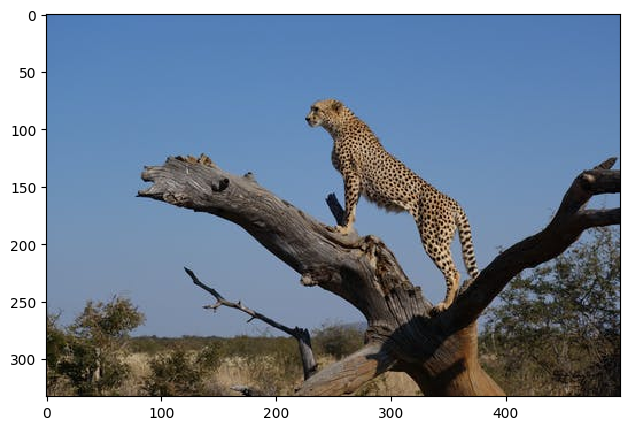

In [4]:
io.imshow(np.array(image_data[0]))

In [5]:
target_size = (max_width, max_height)
resized_images = [img.resize(target_size, Image.Resampling.LANCZOS) for img in image_data]

In [6]:
# Convert the data to numpy arrays
X = np.array(resized_images)
y = np.array(labels)
classes = set(y)

# Encode labels into numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

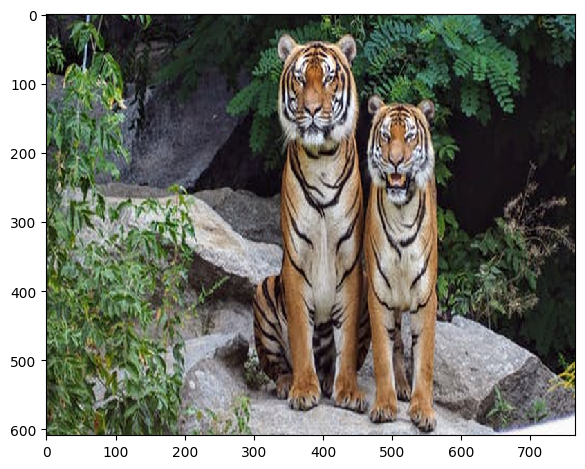

In [7]:
io.imshow(np.array(X_train[0]))
io.imsave('cat_resized.png', np.array(X_train[0]).astype(np.uint8))

## Feature selection & dimensionality reduction

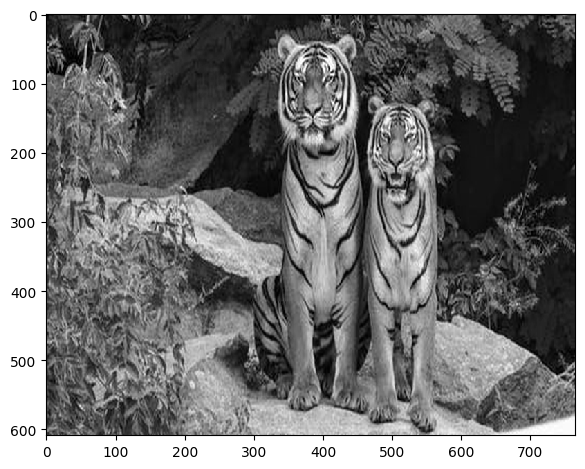

In [8]:
# Convert to grayscale
X_train_gs = [color.rgb2gray(img) for img in X_train]
X_test_gs = [color.rgb2gray(img) for img in X_test]
io.imshow(np.array(X_train_gs[0]))
io.imsave('cat_resized_gs.png', np.array(X_train[0]).astype(np.uint8))

### Fourier transform

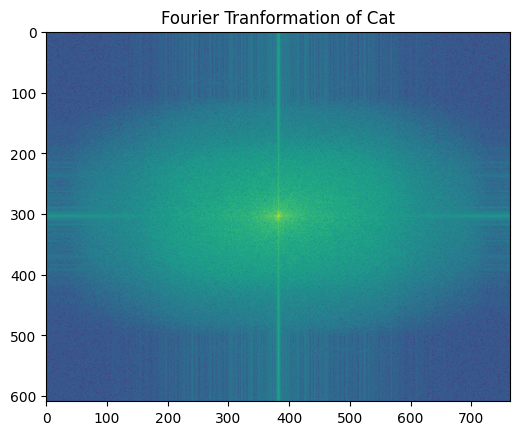

In [9]:
fft_images_train = [fourier_transform(img) for img in X_train_gs]
fft_images_test = [fourier_transform(img) for img in X_test_gs]

img = np.log(abs(fft_images_train[0]))
plt.imshow(img, cmap='viridis')
plt.title("Fourier Tranformation of Cat")
plt.savefig("filtered_cat_fourier.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
low_cutoff_vals = [5, 10, 20, 30, 40, 50]
high_cutoff_vals = [450, 500, 550]

accuracy_results = np.zeros((len(low_cutoff_vals), len(high_cutoff_vals)))

for i, low_co in enumerate(low_cutoff_vals):
    for j, high_co in enumerate(high_cutoff_vals):
        filtered_ftt_images_train = [filter_fourier_image(img, low_co, high_co) for img in fft_images_train]
        filtered_ftt_images_test = [filter_fourier_image(img, low_co, high_co) for img in fft_images_test]
        ifft_images_train = [inverse_fourier_transform(f) for f in filtered_ftt_images_train]
        ifft_images_test = [inverse_fourier_transform(f) for f in filtered_ftt_images_test]
        gnb = GaussianNB()
        gnb.fit([x.flatten() for x in ifft_images_train], y_train)
        y_pred = gnb.predict([x.flatten() for x in ifft_images_test])
        accuracy = accuracy_score(y_test, y_pred)
        print(accuracy, low_co)
        accuracy_results[i, j] = accuracy

In [ ]:
X, Y = np.meshgrid(low_cutoff_vals, high_cutoff_vals)
Z = accuracy_results.T  # Transpose to align correctly with meshgrid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Low Cutoff')
ax.set_ylabel('High Cutoff')
ax.set_zlabel('Accuracy')
ax.view_init(elev=18, azim=130)
ax.set_title('Relationship bandpass filter size and classifier accuracy')
plt.savefig("fourier_dim_red_plot.from sklearn.cluster import DBSCANpng")
plt.show()

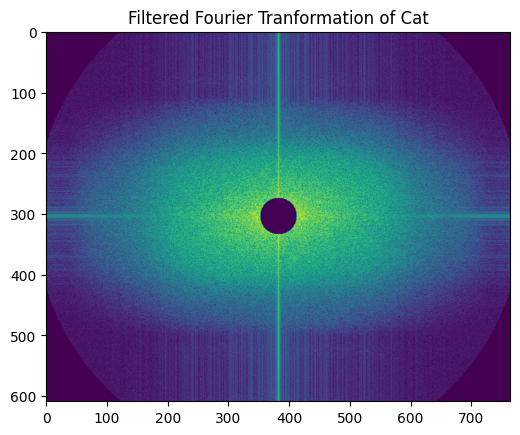

In [10]:
low_cutoff = 30
high_cutoff = 400
filtered_ftt_images_train = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_train]
filtered_ftt_images_test = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_test]
img = np.log(1+abs(filtered_ftt_images_train[0]))
plt.imshow(img, cmap='viridis')
plt.title("Filtered Fourier Tranformation of Cat")
plt.savefig("filtered_cat_fourier.png", bbox_inches='tight', dpi=300)
plt.show()

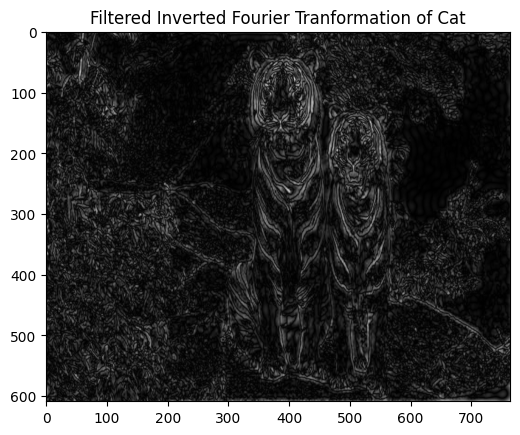

In [11]:
ifft_images_train = [inverse_fourier_transform(f) for f in filtered_ftt_images_train]
ifft_images_test = [inverse_fourier_transform(f) for f in filtered_ftt_images_test]
img = abs(ifft_images_train[0])

plt.imshow(img, cmap='gray')
plt.title("Filtered Inverted Fourier Tranformation of Cat")
plt.savefig("filtered_inverted_cat_fourier.png", bbox_inches='tight', dpi=300)
plt.show()

### SIFT (with bag-of-visual-words)

In [ ]:
sift_features_train = sift_features(X_train_gs)
sift_features_test = sift_features(X_test_gs)

In [17]:
image_histograms_train = bag_of_visual_words(sift_features_train, 300)
image_histograms_test = bag_of_visual_words(sift_features_test, 300)

In [14]:
with open('sift_features_train.pkl', 'wb') as file:
    pickle.dump(sift_features_train, file)

with open('sift_features_test.pkl', 'wb') as file:
    pickle.dump(sift_features_test, file)

In [16]:
with open('sift_features_train.pkl', 'rb') as file:
    sift_features_train = pickle.load(file)

# Load the testing SIFT features
with open('sift_features_test.pkl', 'rb') as file:
    sift_features_test = pickle.load(file)

In [17]:
# Define the parameter space for dict_size
K_values = [20, 50, 100, 200, 300, 500]
accuracies = []

for K in K_values:
    print(K)
    image_histograms_train = bag_of_visual_words(sift_features_train, K)
    image_histograms_test = bag_of_visual_words(sift_features_test, K)

    gnb = GaussianNB()
    gnb.fit([x.flatten() for x in image_histograms_train], y_train) 

    # Make predictions and calculate accuracy
    y_pred = gnb.predict([x.flatten() for x in image_histograms_test])
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the accuracy for the current dict_size
    accuracies.append(accuracy)

20
50
100
200
300
500


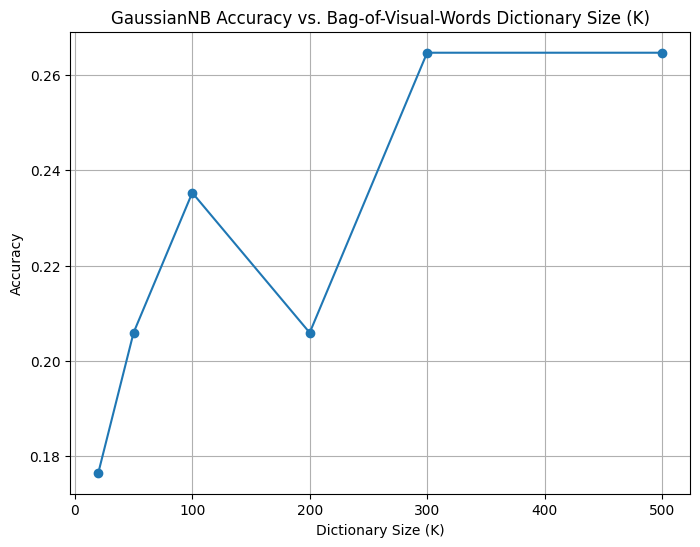

In [19]:
# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(K_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Dictionary Size (K)')
plt.ylabel('Accuracy')
plt.title('GaussianNB Accuracy vs. Bag-of-Visual-Words Dictionary Size (K)')
plt.grid(True)
plt.savefig("bag_of_words.png", bbox_inches='tight', dpi=300)
plt.show()

## Classification

In [21]:
param_grid_lm = {
    'estimator__C': [0.001, 0.01, 0.1] 
}
param_grid_nb = {
    'var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5]
}

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17]
}


### Original data

#### Logistic Regression     

In [108]:
lm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=2000))
#ovr_classifier = OneVsRestClassifier(estimator=lm)
#grid_search_lm = GridSearchCV(estimator=ovr_classifier, param_grid=param_grid_lm, cv=2, scoring='accuracy')
#grid_search_lm.fit([x.flatten() for x in X_train], y_train) 
lm.fit([x.flatten() for x in X_train], y_train) 

# Report the best parameters
#best_params = grid_search_lm.best_params_
#print("Best Parameters:", best_params)

# Retrieve the best model
#best_model_lm = grid_search_lm.best_estimator_

# Evaluate the model on test data
y_pred = lm.predict([x.flatten() for x in X_test])  # Replace X_test with your test data
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Model Accuracy:", accuracy)

Model Accuracy: 0.14705882352941177


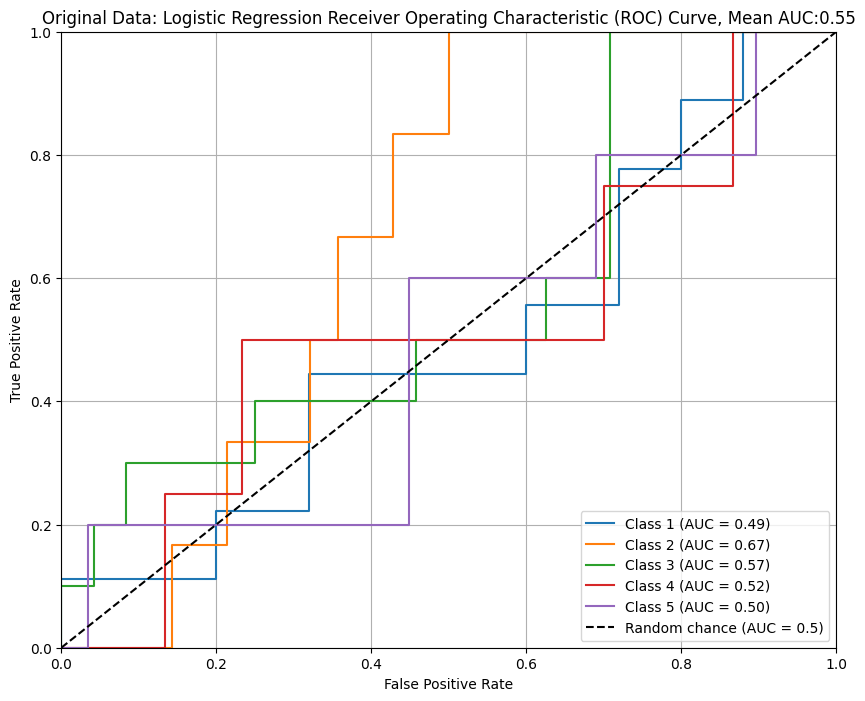

In [109]:
y_scores = lm.predict_proba([x.flatten() for x in X_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Original Data: Logistic Regression Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

#### Naive Bayes

In [110]:
gnb = GaussianNB()
grid_search_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=3, scoring='accuracy')
grid_search_gnb.fit([x.flatten() for x in X_train], y_train) 
#gnb.fit([x.flatten() for x in X_train], y_train) 

# Report the best parameters
best_params = grid_search_gnb.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_gnb = grid_search_gnb.best_estimator_

# Evaluate the model on test data
y_pred = best_model_gnb.predict([x.flatten() for x in X_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy 
print("Model Accuracy:", accuracy)

Best Parameters: {'var_smoothing': 1e-08}
Model Accuracy: 0.20588235294117646


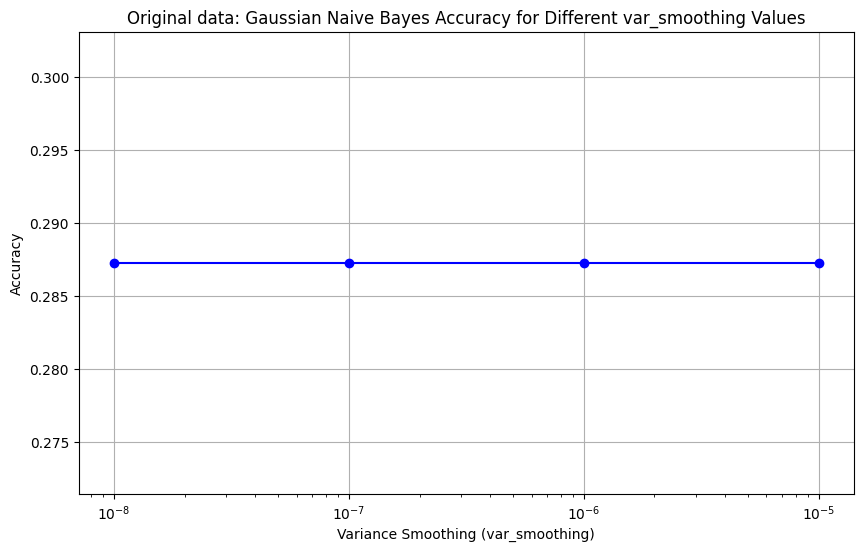

In [111]:
var_smoothing_values = grid_search_gnb.cv_results_['param_var_smoothing'].data  
accuracies = grid_search_gnb.cv_results_['mean_test_score']                     

# Plot accuracies for different var_smoothing values
plt.figure(figsize=(10, 6))
plt.plot(var_smoothing_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xscale('log')
plt.xlabel('Variance Smoothing (var_smoothing)')
plt.ylabel('Accuracy')
plt.title('Original data: Gaussian Naive Bayes Accuracy for Different var_smoothing Values')
plt.grid(True)
plt.savefig("original_gaussian_naive_bayes_accuracy.png")
plt.show()

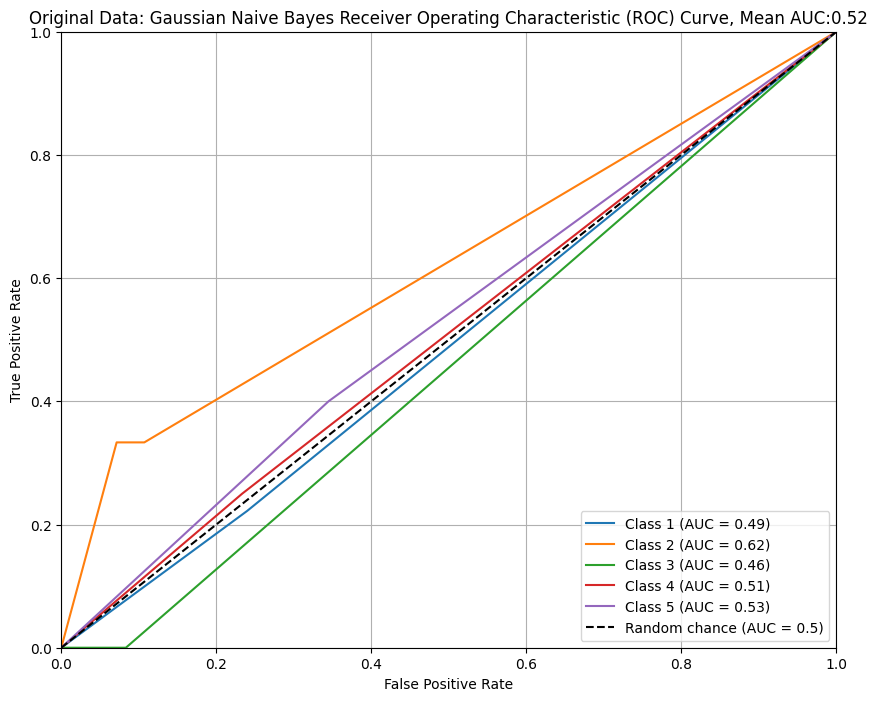

In [112]:
y_scores = best_model_gnb.predict_proba([x.flatten() for x in X_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Original Data: Gaussian Naive Bayes Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

#### K-Nearest-Neighbours

In [113]:
knn = KNeighborsClassifier()  
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit([x.flatten() for x in X_train], y_train) 

# Report the best parameters
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_knn = grid_search_knn.best_estimator_

# Evaluate the model on test data
y_pred = best_model_knn.predict([x.flatten() for x in X_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'n_neighbors': 11}
Best Model Accuracy: 0.2647058823529412


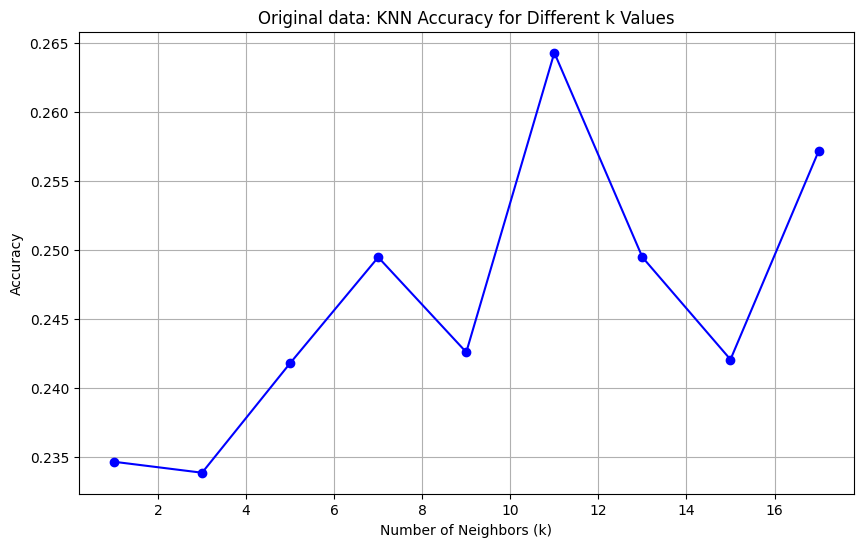

In [114]:
# Extract mean test scores for each k value
k_values = grid_search_knn.cv_results_['param_n_neighbors'].data  
accuracies = grid_search_knn.cv_results_['mean_test_score']      

# Plot accuracies for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Original data: KNN Accuracy for Different k Values')
plt.grid(True)
plt.savefig("original_knn.png")
plt.show()

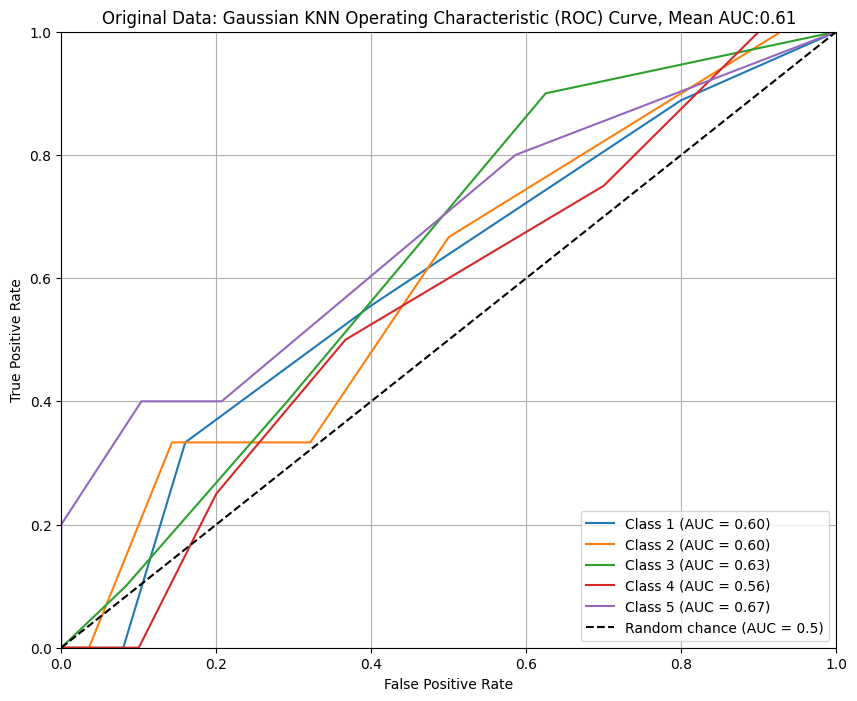

In [115]:
y_scores = best_model_knn.predict_proba([x.flatten() for x in X_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Original Data: Gaussian KNN Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

### Fourier data 

#### Logistic Regression     

In [58]:
lm = LogisticRegression(solver='lbfgs', max_iter=2000)
ovr_classifier = OneVsRestClassifier(estimator=lm)
grid_search_lm = GridSearchCV(estimator=ovr_classifier, param_grid=param_grid_lm, cv=3, scoring='accuracy')
grid_search_lm.fit([x.flatten() for x in ifft_images_train], y_train) 

# Report the best parameters
best_params = grid_search_lm.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_lm = grid_search_lm.best_estimator_

# Evaluate the model on test data
y_pred = best_model_lm.predict([x.flatten() for x in ifft_images_test]) 
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'estimator__C': 0.01}
Best Model Accuracy: 0.4411764705882353


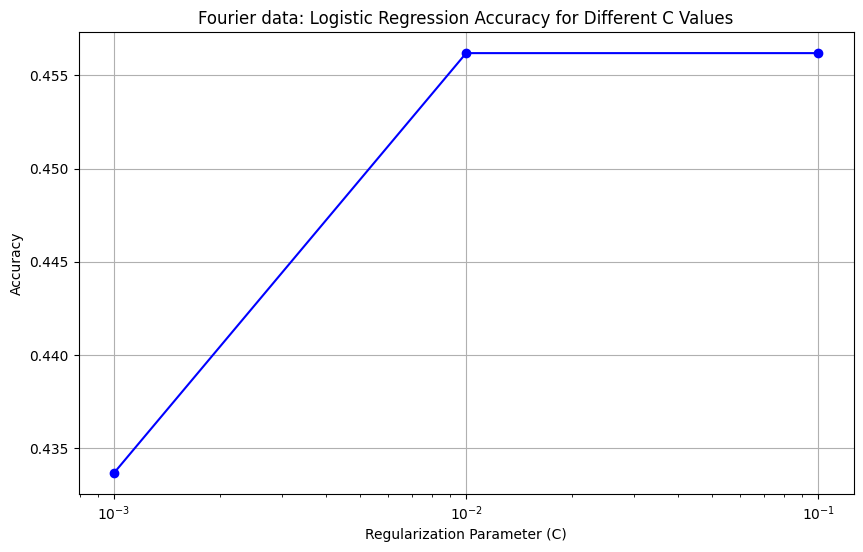

In [117]:
# Extract mean test scores for each C value
c_values = grid_search_lm.cv_results_['param_estimator__C'].data  
accuracies = grid_search_lm.cv_results_['mean_test_score']         

# Plot accuracies for different C values
plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xscale('log')  
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Fourier data: Logistic Regression Accuracy for Different C Values')
plt.grid(True)
plt.savefig("fourier_logistic_regression_accuracy.png")
plt.show()

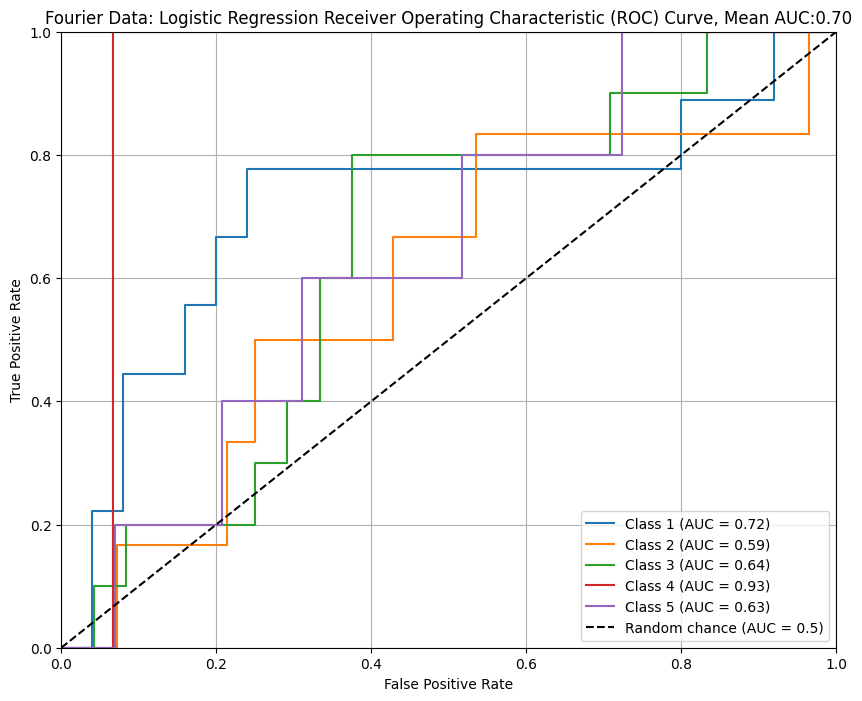

In [30]:
y_scores = best_model_lm.predict_proba([x.flatten() for x in ifft_images_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Fourier Data: Logistic Regression Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

#### Naive Bayes

In [59]:
gnb = GaussianNB()
grid_search_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=3, scoring='accuracy')
grid_search_gnb.fit([x.flatten() for x in ifft_images_train], y_train) 

# Report the best parameters
best_params = grid_search_gnb.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_gnb = grid_search_gnb.best_estimator_

# Evaluate the model on test data
y_pred = best_model_gnb.predict([x.flatten() for x in ifft_images_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'var_smoothing': 1e-08}
Best Model Accuracy: 0.38235294117647056


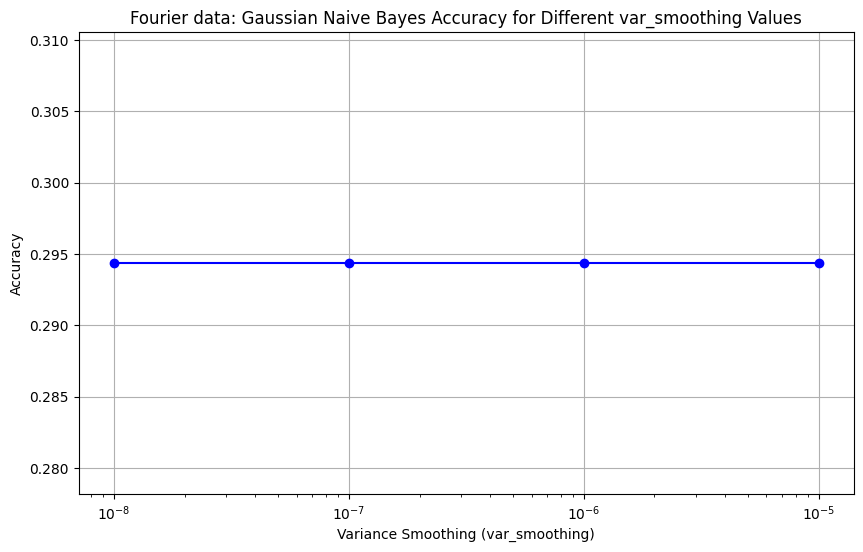

In [120]:
var_smoothing_values = grid_search_gnb.cv_results_['param_var_smoothing'].data  
accuracies = grid_search_gnb.cv_results_['mean_test_score']                     

# Plot accuracies for different var_smoothing values
plt.figure(figsize=(10, 6))
plt.plot(var_smoothing_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xscale('log')
plt.xlabel('Variance Smoothing (var_smoothing)')
plt.ylabel('Accuracy')
plt.title('Fourier data: Gaussian Naive Bayes Accuracy for Different var_smoothing Values')
plt.grid(True)
plt.savefig("fourier_gaussian_naive_bayes_accuracy.png")
plt.show()

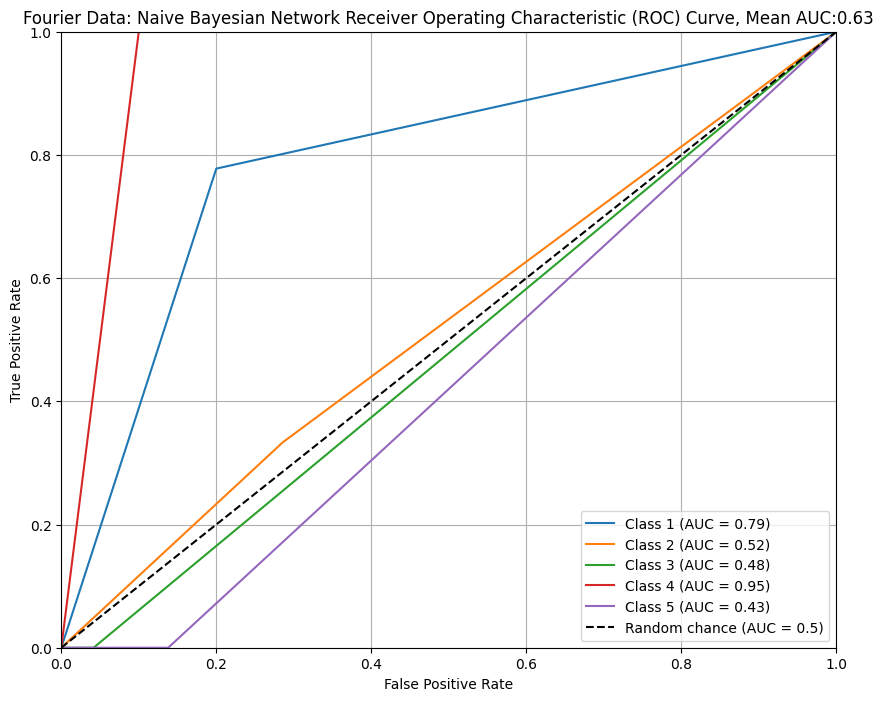

In [31]:
y_scores = best_model_gnb.predict_proba([x.flatten() for x in ifft_images_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Fourier Data: Naive Bayesian Network Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

#### K-Nearest-Neighbours

In [60]:
knn = KNeighborsClassifier()  
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=3, scoring='accuracy')
grid_search_knn.fit([x.flatten() for x in ifft_images_train], y_train) 

# Report the best parameters
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_knn = grid_search_knn.best_estimator_

# Evaluate the model on test data
y_pred = best_model_knn.predict([x.flatten() for x in ifft_images_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'n_neighbors': 1}
Best Model Accuracy: 0.20588235294117646


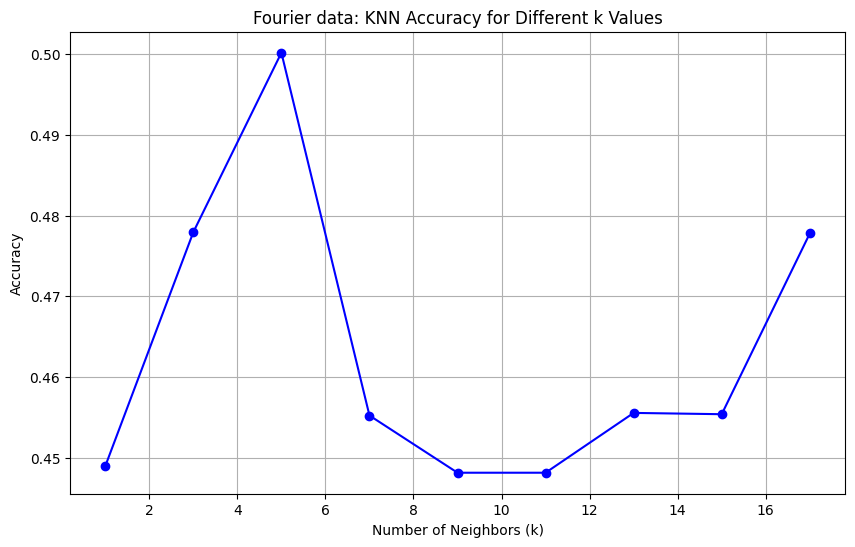

In [50]:
# Extract mean test scores for each k value
k_values = grid_search_knn.cv_results_['param_n_neighbors'].data 
accuracies = grid_search_knn.cv_results_['mean_test_score']       

# Plot accuracies for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Fourier data: KNN Accuracy for Different k Values')
plt.grid(True)
plt.savefig("fourier_knn.png")
plt.show()

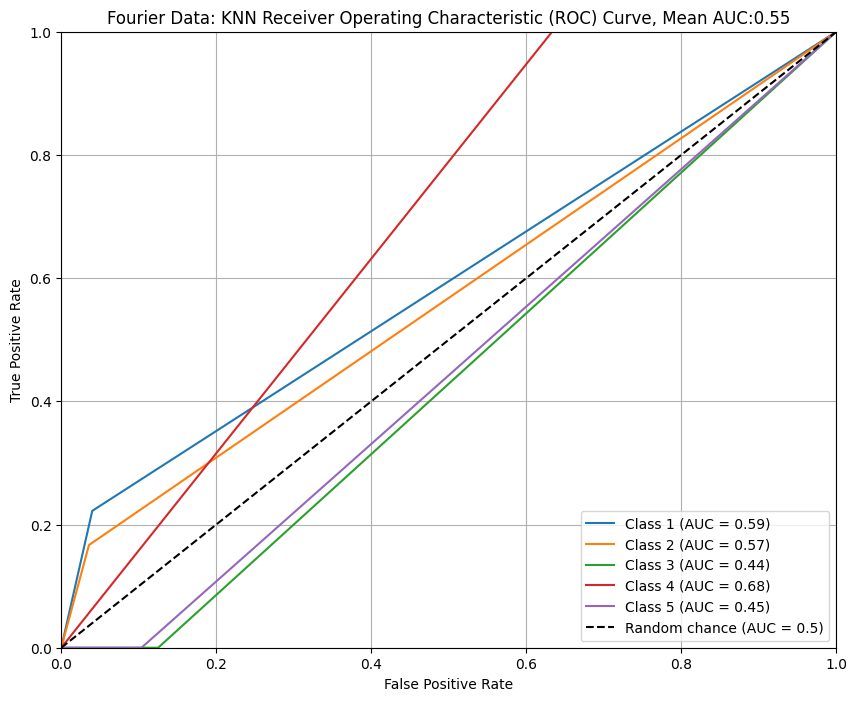

In [32]:
y_scores = best_model_knn.predict_proba([x.flatten() for x in ifft_images_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Fourier Data: KNN Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

In [56]:
best_param_model_lm = best_model_lm
best_param_model_gnb = best_model_gnb
best_param_model_knn = best_model_knn

### SIFT features

#### Logistic Regression     

In [55]:
lm = LogisticRegression(solver='lbfgs', max_iter=2000)
ovr_classifier = OneVsRestClassifier(estimator=lm)
grid_search_lm = GridSearchCV(estimator=ovr_classifier, param_grid=param_grid_lm, cv=3, scoring='accuracy')
grid_search_lm.fit([x.flatten() for x in image_histograms_train], y_train) 

# Report the best parameters
best_params = grid_search_lm.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_lm = grid_search_lm.best_estimator_

# Evaluate the model on test data
y_pred = best_model_lm.predict([x.flatten() for x in image_histograms_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'estimator__C': 0.001}
Best Model Accuracy: 0.20588235294117646


[0.60338164 0.59597424 0.58856683]


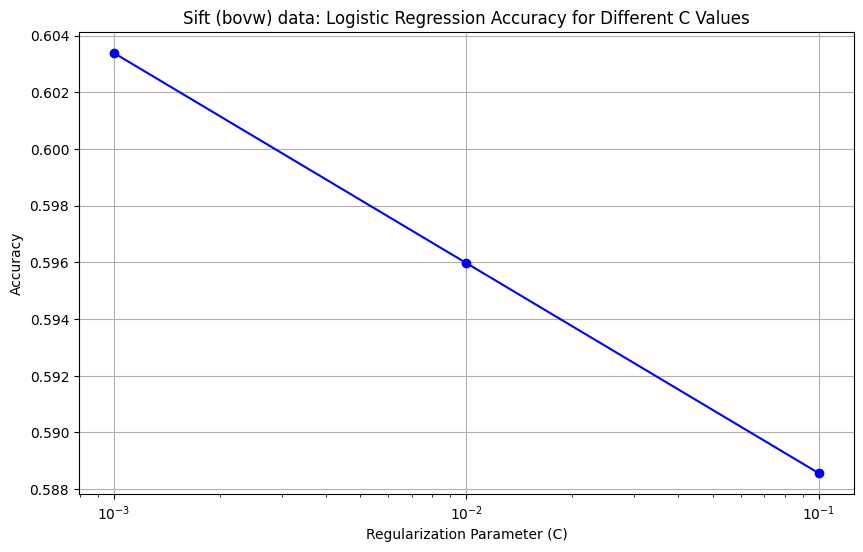

In [36]:
# Extract mean test scores for each C value
c_values = grid_search_lm.cv_results_['param_estimator__C'].data 
accuracies = grid_search_lm.cv_results_['mean_test_score']         
print(accuracies)
# Plot accuracies for different C values
plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xscale('log')  
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Sift (bovw) data: Logistic Regression Accuracy for Different C Values')
plt.grid(True)
plt.savefig("sift_logistic_regression_accuracy.png")
plt.show()

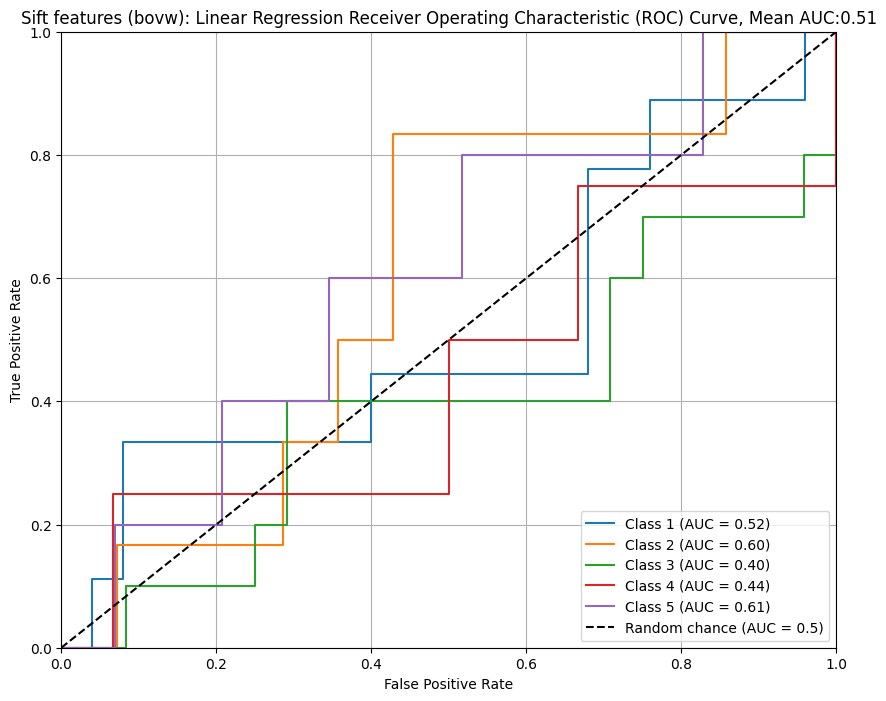

In [37]:
y_scores = best_model_lm.predict_proba([x.flatten() for x in image_histograms_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Sift features (bovw): Linear Regression Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

#### Naive Bayes

In [39]:
gnb = GaussianNB()
grid_search_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=3, scoring='accuracy')
grid_search_gnb.fit([x.flatten() for x in image_histograms_train], y_train) 

# Report the best parameters
best_params = grid_search_gnb.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_gnb = grid_search_gnb.best_estimator_

# Evaluate the model on test data
y_pred = best_model_gnb.predict([x.flatten() for x in image_histograms_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'var_smoothing': 1e-08}
Best Model Accuracy: 0.20588235294117646


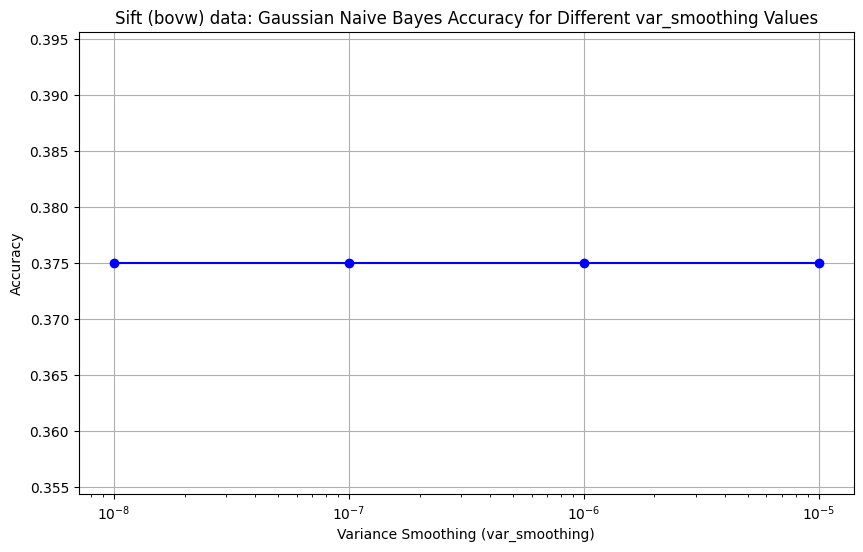

In [40]:
var_smoothing_values = grid_search_gnb.cv_results_['param_var_smoothing'].data  
accuracies = grid_search_gnb.cv_results_['mean_test_score']                     

# Plot accuracies for different var_smoothing values
plt.figure(figsize=(10, 6))
plt.plot(var_smoothing_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xscale('log')
plt.xlabel('Variance Smoothing (var_smoothing)')
plt.ylabel('Accuracy')
plt.title('Sift (bovw) data: Gaussian Naive Bayes Accuracy for Different var_smoothing Values')
plt.grid(True)
plt.savefig("sift_gaussian_naive_bayes_accuracy.png")
plt.show()

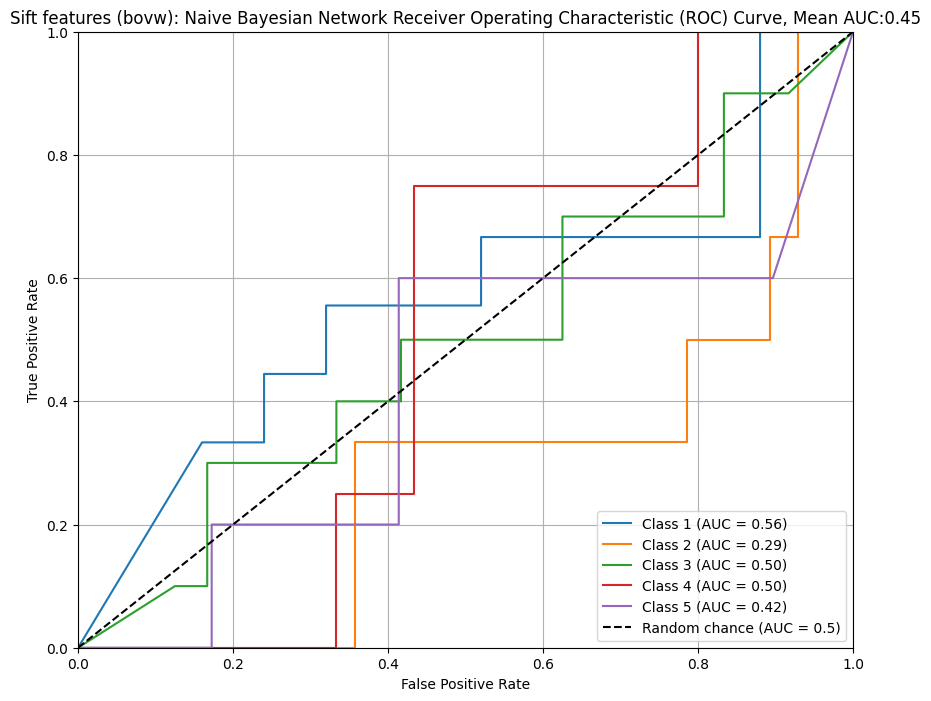

In [41]:
y_scores = best_model_gnb.predict_proba([x.flatten() for x in image_histograms_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Sift features (bovw): Naive Bayesian Network Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

#### K-Nearest-Neighbours

In [43]:
knn = KNeighborsClassifier()  
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=3, scoring='accuracy')
grid_search_knn.fit([x.flatten() for x in image_histograms_train], y_train) 

# Report the best parameters
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model_knn = grid_search_knn.best_estimator_

# Evaluate the model on test data
y_pred = best_model_knn.predict([x.flatten() for x in image_histograms_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy
print("Best Model Accuracy:", accuracy)

Best Parameters: {'n_neighbors': 5}
Best Model Accuracy: 0.2647058823529412


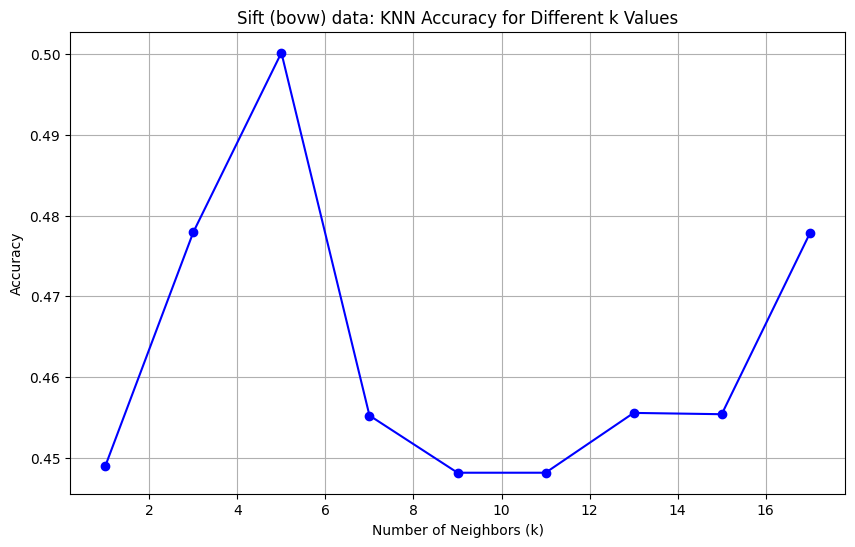

In [44]:
# Extract mean test scores for each k value
k_values = grid_search_knn.cv_results_['param_n_neighbors'].data  # `param_n_neighbors` holds the k values
accuracies = grid_search_knn.cv_results_['mean_test_score']       # Mean accuracy scores for each k

# Plot accuracies for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Sift (bovw) data: KNN Accuracy for Different k Values')
plt.grid(True)
plt.savefig("sift_knn.png")
plt.show()

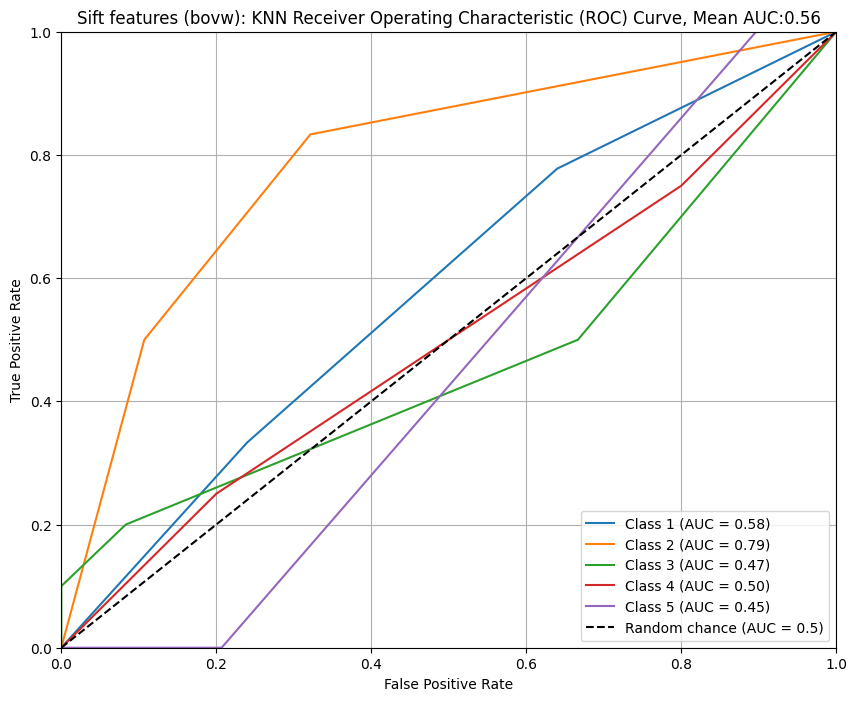

In [47]:
y_scores = best_model_knn.predict_proba([x.flatten() for x in image_histograms_test])
auc_val = roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr")
plot_ROC(y_test, y_scores, f"Sift features (bovw): KNN Receiver Operating Characteristic (ROC) Curve, Mean AUC:{auc_val:.2f}")

## Data Augmentation

In [15]:
# augmentation functions
def random_noise(image_array: np.ndarray):
    # Add random noise to the image
    return util.random_noise(image_array)

def horizontal_flip(image_array: np.ndarray):
    # Flip the image horizontally
    return np.fliplr(image_array)

def augment_data(X_train, y_train, num_augmented_images_per_image=3):
    X_augmented = []
    y_augmented = []
    
    for image, label in zip(X_train, y_train):
        for _ in range(num_augmented_images_per_image):
            # Choose a random augmentation to apply
            augmentation_choice = np.random.choice(['rotate', 'noise', 'flip'])
            if augmentation_choice == 'noise':
                augmented_image = random_noise(image)
            elif augmentation_choice == 'flip':
                augmented_image = horizontal_flip(image)
                
                X_augmented.append(augmented_image)
                y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)


# Apply augmentation
num_augmented_images_per_image = 2
X_train_augmented_part, y_train_augmented_part = augment_data(X_train_gs, y_train, num_augmented_images_per_image)
X_train_augmented = np.concatenate((X_train_gs, X_train_augmented_part), axis=0)
y_train_augmented = np.concatenate((y_train, y_train_augmented_part), axis=0)



In [16]:
fft_images_train = [fourier_transform(img) for img in X_train_augmented]
low_cutoff = 30
high_cutoff = 400
filtered_ftt_images_train = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_train]
ifft_images_train = [inverse_fourier_transform(f) for f in filtered_ftt_images_train]

In [20]:
lm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=2000))
lm.fit([x.flatten() for x in ifft_images_train], y_train_augmented) 

# Evaluate the model on test data
y_pred = lm.predict([x.flatten() for x in ifft_images_test])  
accuracy = accuracy_score(y_test, y_pred)

# Report accuracy and roc auc
y_scores = lm.predict_proba([x.flatten() for x in ifft_images_test])
print("roc-auc:", roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr"))
print("Best Model Accuracy:", accuracy)

0.6394105090311987
Best Model Accuracy: 0.2647058823529412


## Ensemble

In [61]:
ensemble_model = VotingClassifier(
    estimators=[
        ('knn', best_param_model_knn),
        ('lm', best_param_model_lm),
        ('gnb', best_param_model_gnb)
    ],
    voting='hard'  # 'hard' uses majority voting
)
# Train the model
ensemble_model.fit([x.flatten() for x in ifft_images_train], y_train)

# Predict with ensemble model
y_pred = ensemble_model.predict([x.flatten() for x in ifft_images_test])
accuracy = accuracy_score(y_test, y_pred)
y_scores = best_model_lm.predict_proba([x.flatten() for x in ifft_images_test])

# Report accuracy and roc-auc
print("Best Model Accuracy:", accuracy)
print(roc_auc_score(y_test, y_scores, average="macro", multi_class="ovr"))

Best Model Accuracy: 0.35294117647058826
0.7020314723590586


## Clustering

Mean Silhouette Score for Fuzzy C-Means: 0.0333


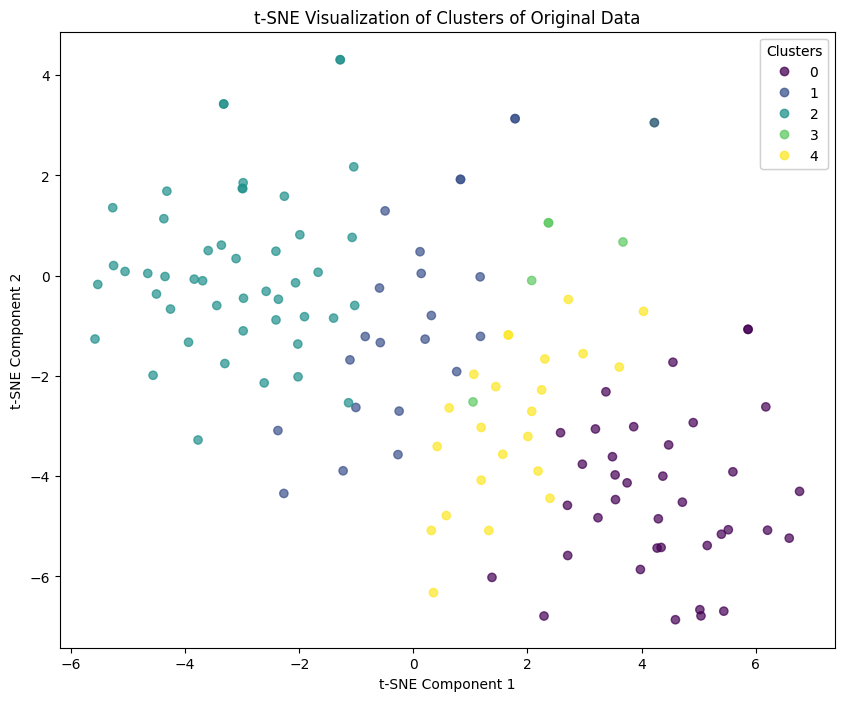

In [12]:
fuzzy_clustering([x.flatten() for x in X_train], "t-SNE Visualization of Clusters of Original Data")

Mean Silhouette Score for Fuzzy C-Means: 0.0958


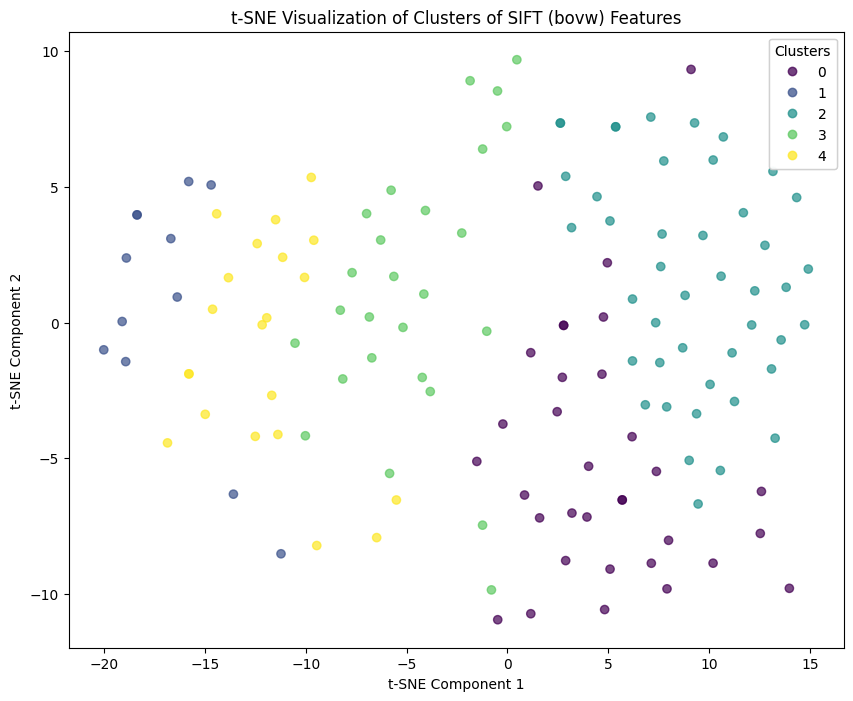

In [18]:
fuzzy_clustering([x.flatten() for x in image_histograms_train], "t-SNE Visualization of Clusters of SIFT (bovw) Features")

Mean Silhouette Score for Fuzzy C-Means: 0.0990


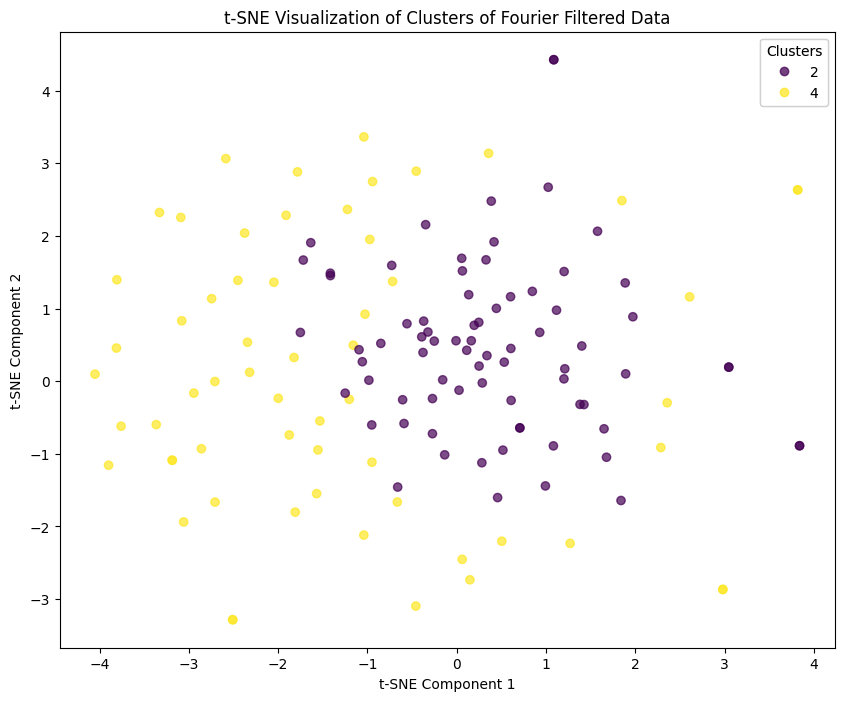

In [14]:
fuzzy_clustering([x.flatten() for x in ifft_images_train], "t-SNE Visualization of Clusters of Fourier Filtered Data")